# WASP-39b joint analysis assuming white noise

**Author:** Hannu Parviainen </br>
**Edited:** 2025-08-08 </br>
**ExoIris version:** 0.18

This notebook carries out an ExoIris transmission spectroscopy analysis for the JWST observations of WASP-39b reduced by [Carter et al. (2024)](https://www.nature.com/articles/s41550-024-02292-x).

**Note:** This notebook assumes you have already read the basic [ExoIris tutorials](https://exoiris.readthedocs.io/en/latest/examples/index.html).

In [1]:
%run ../setup_multiprocessing.py

In [4]:
import xarray as xa

from pathlib import Path
from numpy import *
from matplotlib.pyplot import *

from multiprocessing import Pool
from astropy.time import Time
from exoiris import ExoIris, TSData, TSDataGroup, load_model
from exoiris.ephemeris import Ephemeris

In [5]:
%run core.py

# Read in the data

In [9]:
datadir = Path('data/ZENODO/1_TIME_SERIES_SPECTRA/')

In [10]:
def read_prism():
    d = read_data(datadir / 'NIRSpec_PRISM_Spectra.h5', 'NIRSPec PRISM', ephemeris=eph, egroup=0, ngroup=0, bgroup=0)
    d.crop_wavelength(2.0, 5.5)  # The PRISM data is mostly saturated for l < 2.0 microns.
    d = d.bin_time(bw=30, estimate_errors=False)
    d.normalize_to_poly()
    d.mask_outliers(sigma=10)
    d.normalize_to_poly()
    d.estimate_average_uncertainties()
    return d

def read_nircam():
    d = read_data(datadir / 'NIRCam_F322W2_Spectra.h5', 'NIRCam F322W2', ephemeris=eph, egroup=1, ngroup=1, bgroup=1)
    d.crop_wavelength(d.wavelength[0], 4.0)
    d.crop_time(2459783.32, inf)
    d.normalize_to_poly()
    d.mask_outliers()
    d.normalize_to_poly()
    d = d.bin_wavelength(r=600, estimate_errors=False)
    d.estimate_average_uncertainties()
    return d

def read_nirspec():
    d1 = read_data(datadir / 'NIRSpec_G395H_NRS1_Spectra.h5', 'NIRSpec NRS1', ephemeris=eph, egroup=2, ngroup=2, bgroup=2)
    d1.normalize_to_poly()
    d1.crop_wavelength(2.85, np.inf)
    d1 = d1.bin_wavelength(r=600)
    ds1 = d1.partition_time(((2459791.45, 2459791.62), (2459791.625, np.inf)))

    d2 = read_data(datadir / 'NIRSpec_G395H_NRS2_Spectra.h5', 'NIRSpec NRS2', ephemeris=eph, egroup=2, ngroup=3, bgroup=3)
    d2.normalize_to_poly()
    d2 = d2.bin_wavelength(r=600)
    ds2 = d2.partition_time(((2459791.45, 2459791.62), (2459791.625, np.inf)))
    ds = ds1 + ds2
    
    for d in ds:
        d.mask_outliers()
        d.normalize_to_poly()
        d.estimate_average_uncertainties()
    return ds

def read_niriss():
    d1 = read_data(datadir / 'NIRISS_SOSS_Order1_Spectra.h5', 'NIRISS O1', ephemeris=eph, egroup=3, ngroup=4, bgroup=4)
    d1.crop_wavelength(0.86, 2.8)
    d1.normalize_to_poly()
    d1.mask_outliers(10)
    d1 = d1.bin_wavelength(r=300, estimate_errors=False)
    d1.estimate_average_uncertainties()
    
    d2 = read_data(datadir / 'NIRISS_SOSS_Order2_Spectra.h5', 'NIRISS O2', ephemeris=eph, egroup=3, ngroup=5, bgroup=4)
    d2.crop_wavelength(0.6, 0.84)
    d2.normalize_to_poly()
    d2.mask_outliers(10)
    d2 = d2.bin_wavelength(r=800, estimate_errors=False)
    d2.estimate_average_uncertainties()
    return d1 + d2    

In [11]:
data = read_prism() + read_nircam() + read_nirspec() + read_niriss()

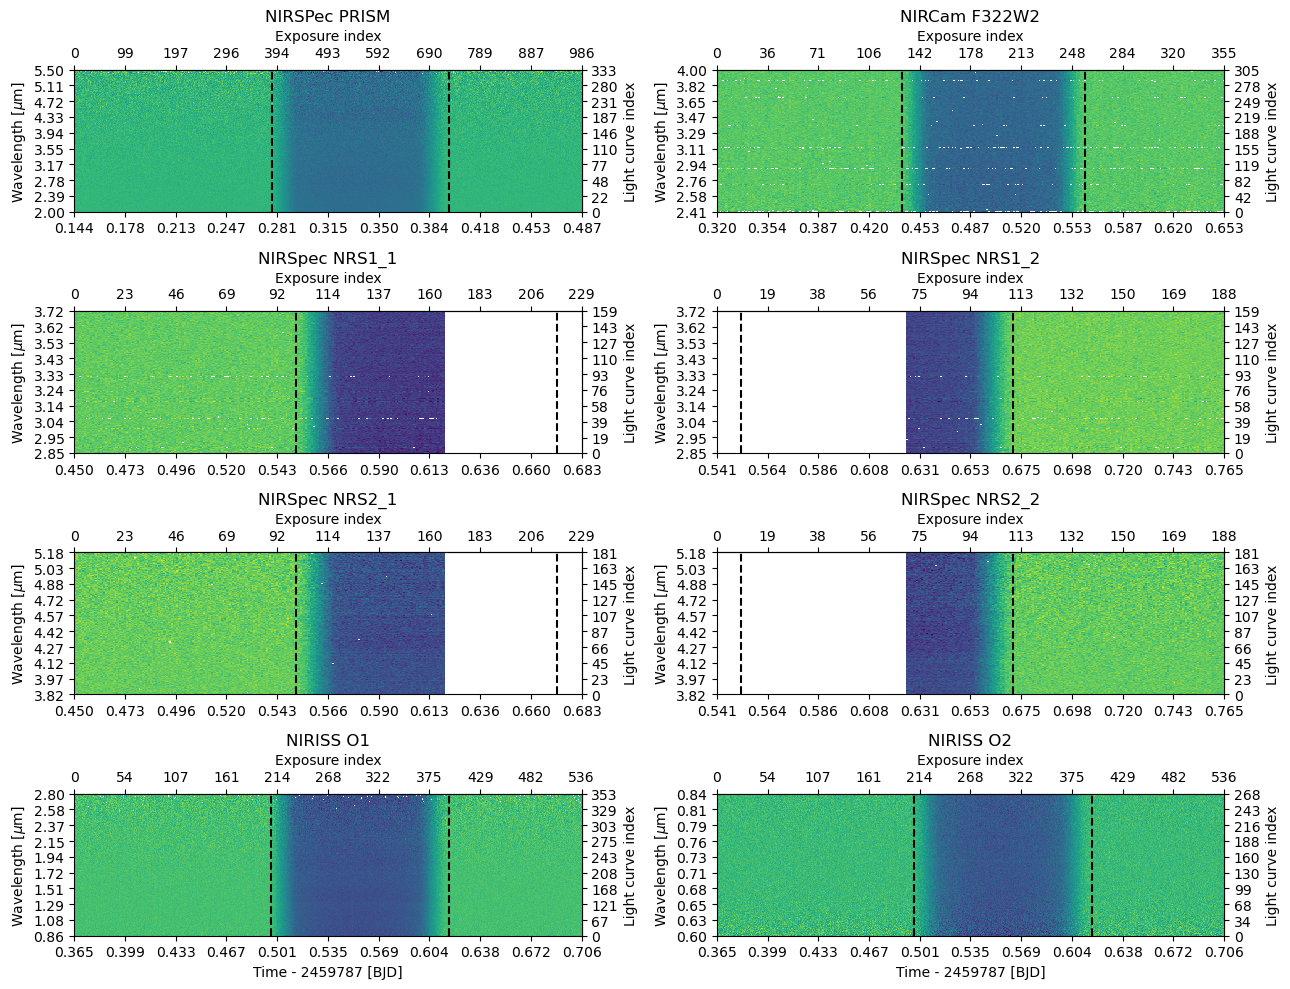

In [12]:
data.plot(ncols=2, figsize=(13, 10)).tight_layout();

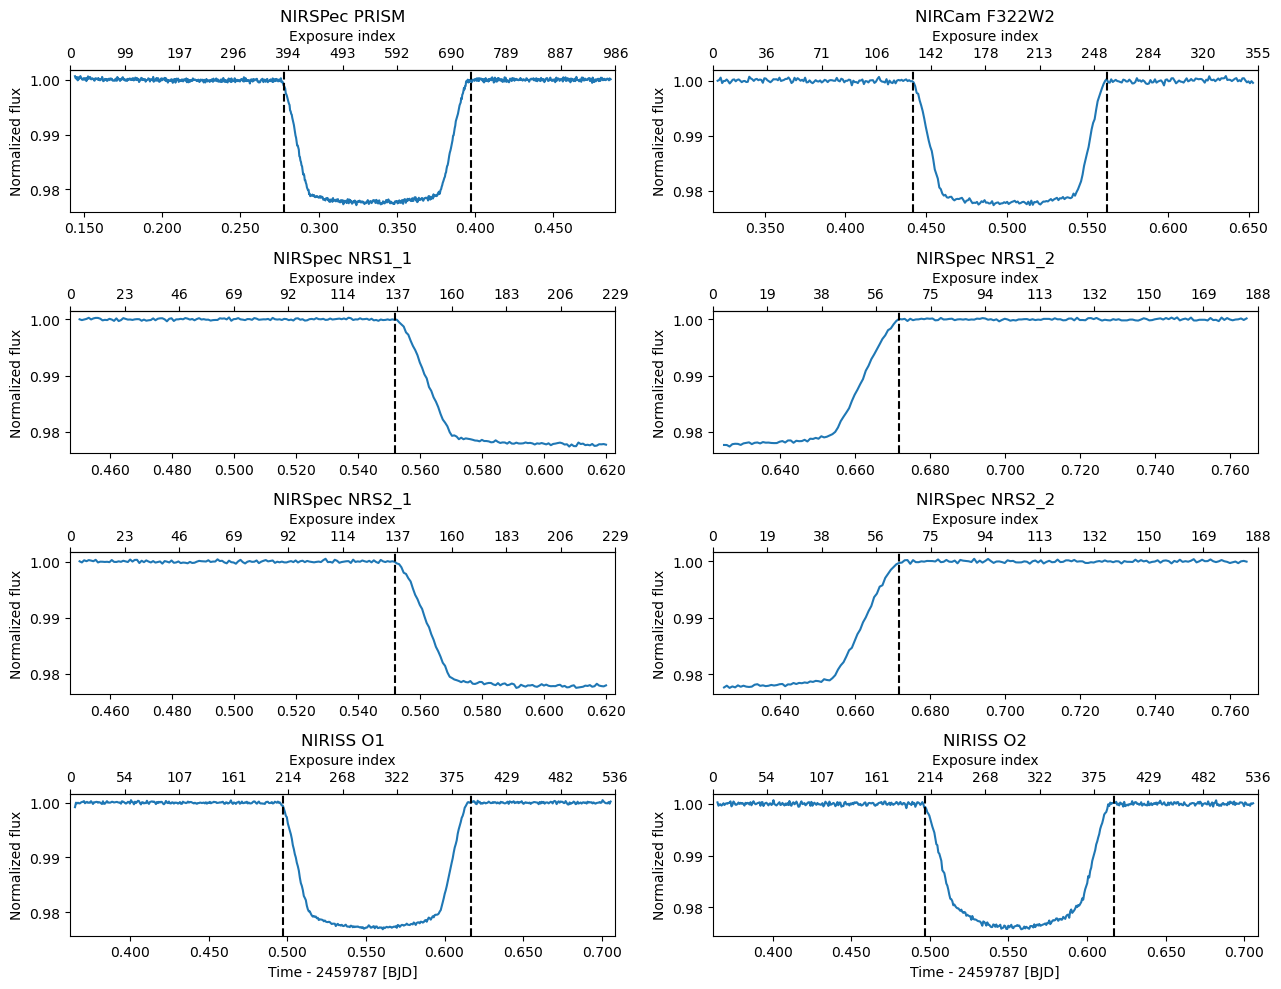

In [7]:
data.plot_white(ncols=2, figsize=(13, 10)).tight_layout();

# Set up the ExoIris analysis

In [7]:
ts = ExoIris('WASP-39b-joint-k100', 'power-2', data, nk=100)
ts.set_prior('tc_00', 'NP', 2459771.34, 0.02)
ts.set_prior('tc_01', 'NP', 2459783.50, 0.02)
ts.set_prior('tc_02', 'NP', 2459791.62, 0.02)
ts.set_prior('tc_03', 'NP', 2459787.55, 0.02)
ts.set_prior('p', 'NP', 4.05487, 1e-4)
ts.set_prior('rho', 'NP', 1.2, 0.01)
ts.set_radius_ratio_prior('UP', 0.14, 0.155)
ts.set_ldtk_prior(teff=(5327, 139), logg=(4.38, 0.09), metal=(-0.01, 0.1), uncertainty_multiplier=10)

In [8]:
for i in range(8):
    ts.set_prior(f'bl_0{i}_c', 'NP', 1.0, 0.002)

In [9]:
for i in range(1, 5):
    ts.set_prior(f'bias_0{i}', 'NP', 0.0, 0.002)

In [10]:
for i in range(data.n_noise_groups):
    ts.set_prior(f'sigma_m_0{i}', 'UP', 0.9, 1.3)

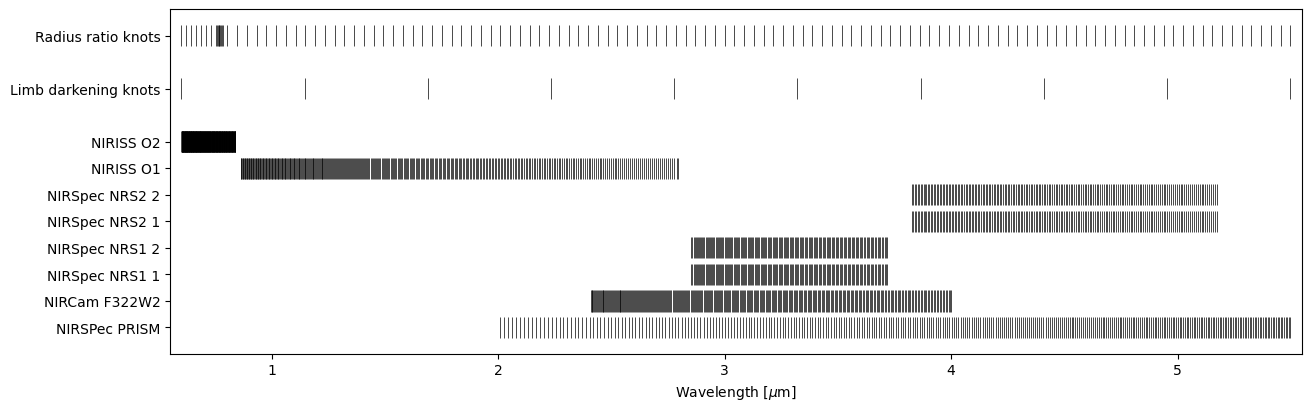

In [24]:
knots = concatenate([linspace(data.wlmin, 0.768-0.015, 7, endpoint=False),
             linspace(0.768 - 0.015, 0.768 + 0.015, 9),
             linspace(0.768 + 0.015 + 0.02, data.wlmax, 110)])
ts.set_radius_ratio_knots(knots)
ts.plot_setup(figsize=(13, 4));

In [25]:
ts.fit_white(4000)

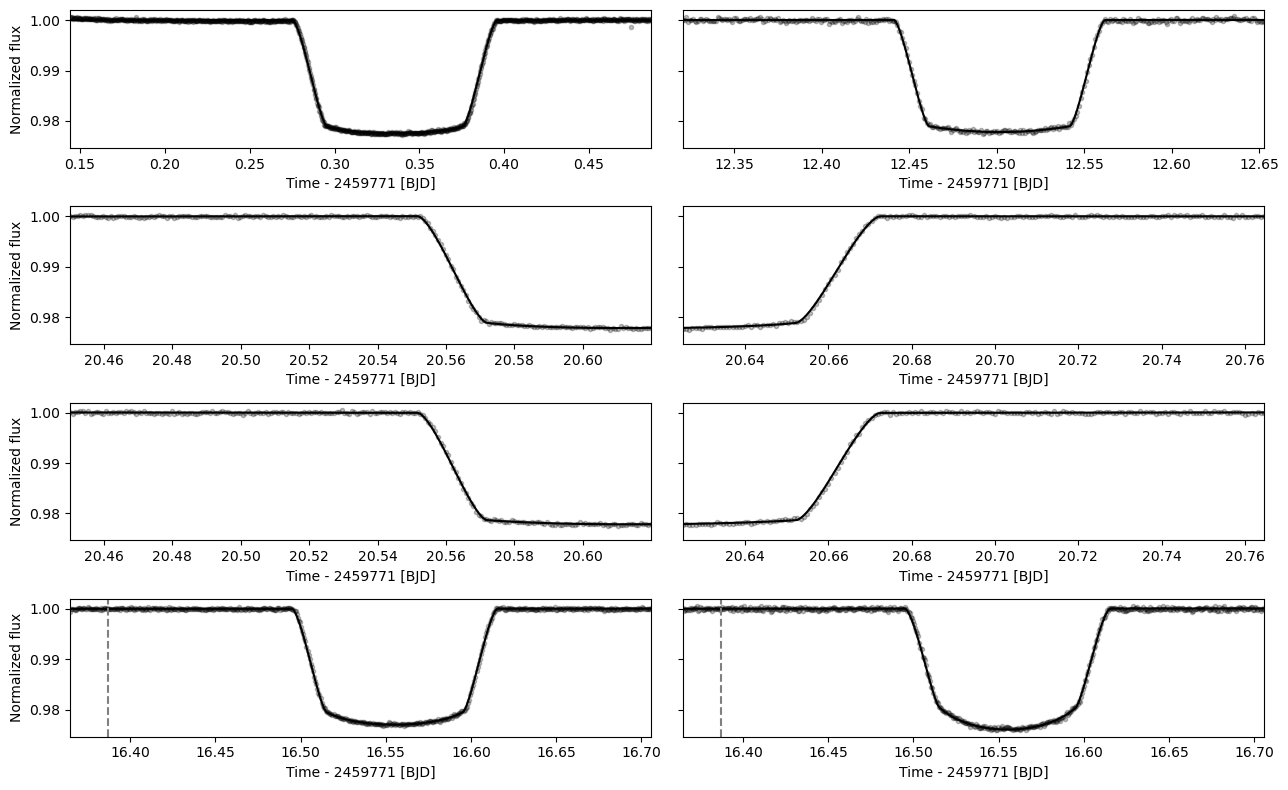

In [26]:
ts.plot_white(ncols=2, figsize=(13,8)).tight_layout()

In [27]:
ts.transit_duration = 0.12

In [28]:
ts.save(overwrite=True)

In [29]:
def lnpostf(pv):
    return ts.lnposterior(pv)

pool = Pool(8)

Global optimisation:   0%|          | 0/25000 [00:00<?, ?it/s]

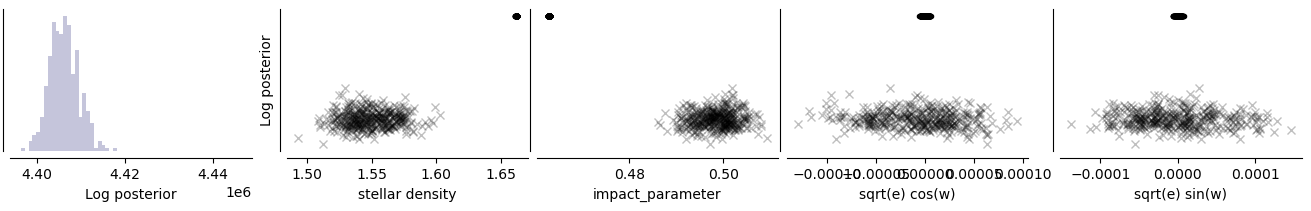

In [33]:
ts.fit(niter=25000, npop=400, pool=pool, lnpost=lnpostf)

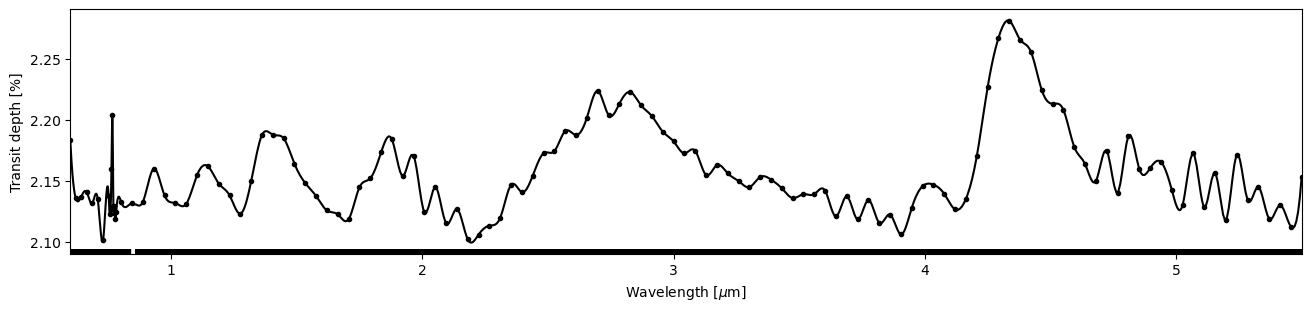

In [34]:
fig, ax = subplots(figsize=(13, 3), constrained_layout=True)
ts.plot_transmission_spectrum(ax=ax, xscale='linear');

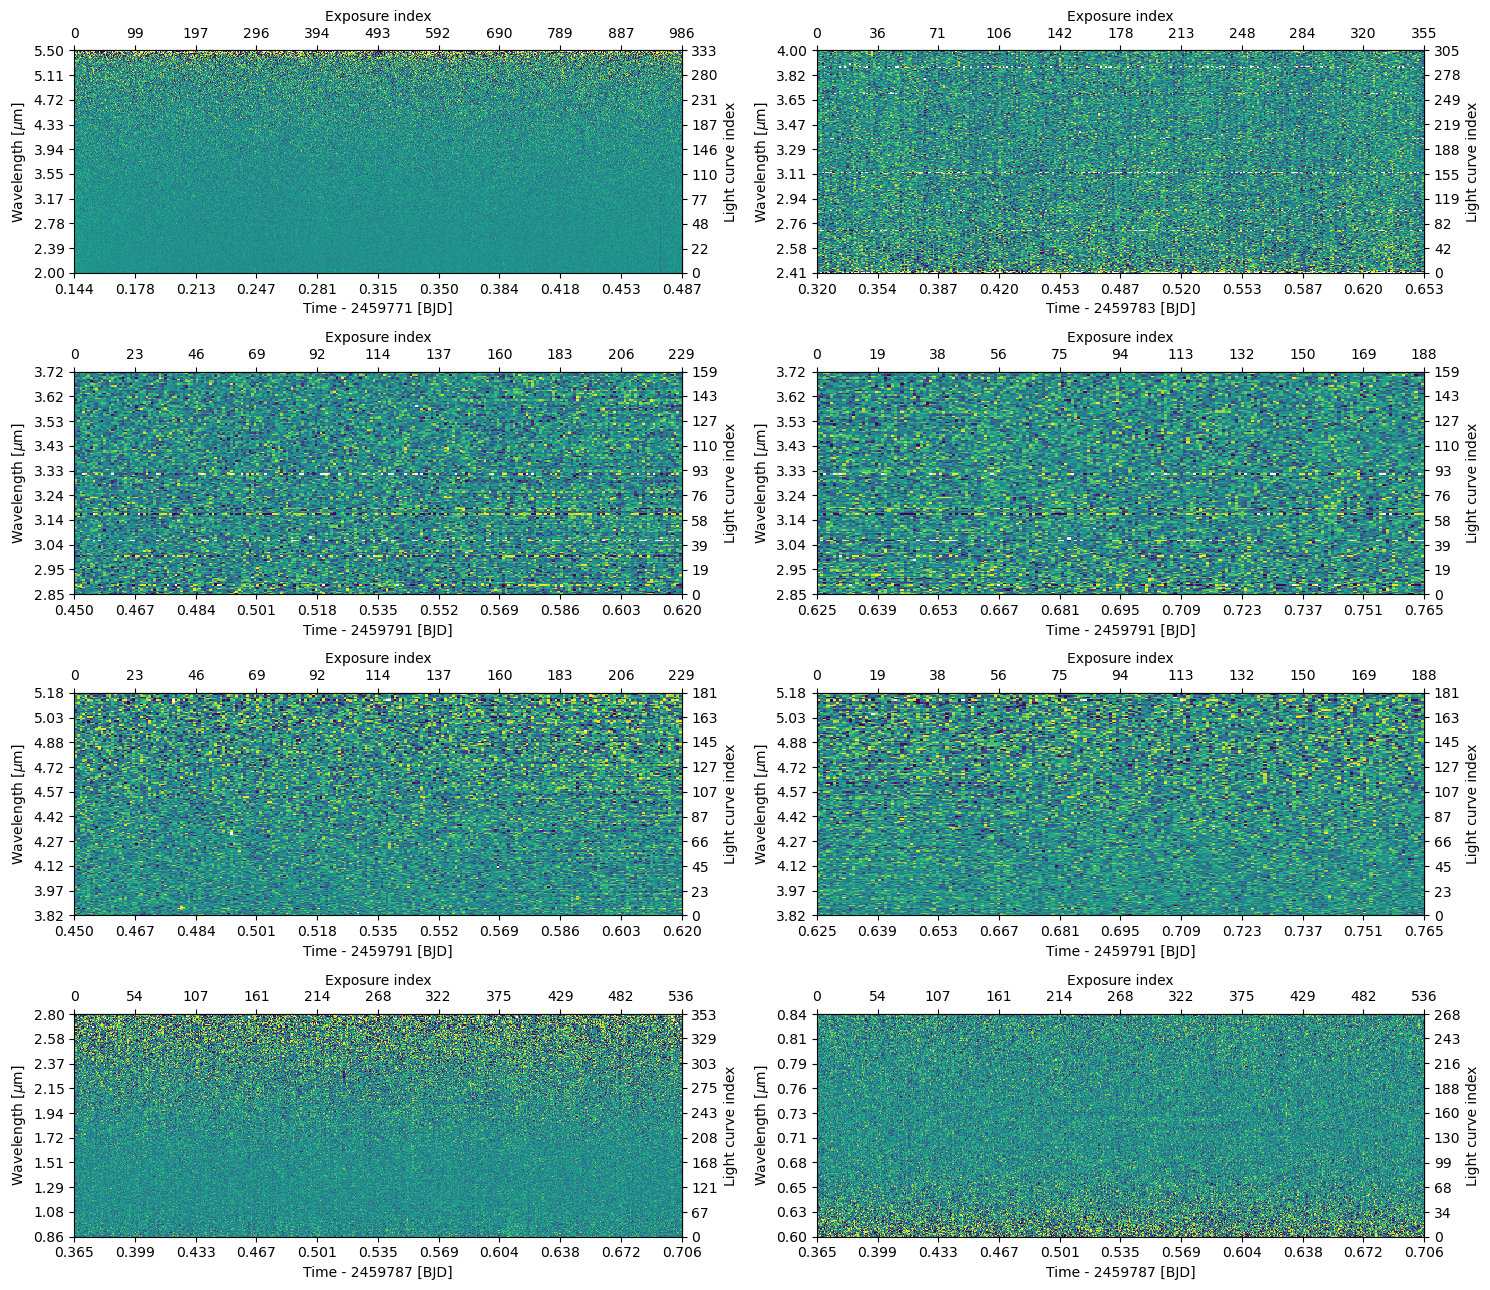

In [35]:
fig, axs = subplots(4, 2, figsize=(15, 13), constrained_layout=True)
ts.plot_residuals(ax=axs.flat);

In [36]:
ts.save()

In [ ]:
for i in range(10):
    ts.sample(1000, thin=100, repeats=1, pool=pool, lnpost=lnpostf)
    ts.save()

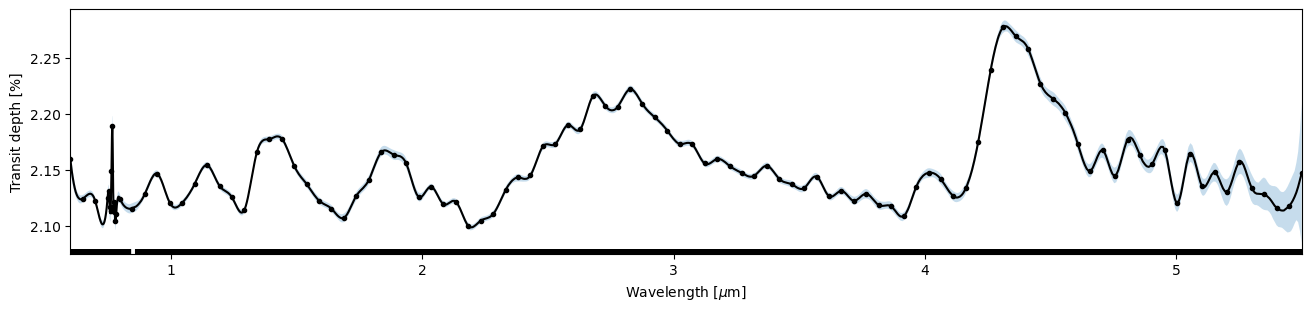

In [63]:
fig, ax = subplots(figsize=(13, 3), constrained_layout=True)
ts.plot_transmission_spectrum('mcmc', ax=ax, xscale='linear');

In [ ]:
pool.close()

---

<center>&copy;2025 Hannu Parviainen</center>